# How to Extract Training and Prediction Matrices

While the primary goal of building forecasting models is to predict future values, it is equally important to evaluate if the model is effectively learning from the training data. Analyzing predictions on the training data or exploring the prediction matrices is crucial for assessing model performance and understanding areas for optimization. This process can help identify issues like overfitting or underfitting, as well as provide deeper insights into the model’s decision-making process.

**Training matrices**

Training matrices contain the input features used by the model during the training process. These matrices are essential for understanding how the model interprets patterns and relationships within the data. They typically include the lagged variables, window features and exogenous variables. By extracting and analyzing these matrices, you can ensure that the input data is correctly structured and aligned with the model’s requirements.


**Prediction matrices**

Prediction matrices are used to generate forecasts for future values. These matrices incorporate the features necessary for making predictions, such as recent observations (lags), window features and any exogenous variables. Understanding the structure of these matrices is important for debugging and for validating the model’s future predictions.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

If any <a href="../user_guides/sklearn-transformers-and-pipeline.html">data transformations</a> and/or <a href="../user_guides/time-series-differentiation.html">differentiation</a>, are applied, they will affect the output matrices. Consequently, the predictions generated in this transformed scale may require additional steps to revert back to the original data scale.

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirect, ForecasterDirectMultiVariate
from skforecast.plot import set_dark_theme

In [2]:
# Download data single series
# ==============================================================================
data = fetch_dataset(
    name="h2o", kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)
print("")

data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Download data ForecasterRecursiveMultiSeries
# ==============================================================================
data_multiseries = fetch_dataset(name="items_sales")
print("")

# Download data ForecasterDirectMultiVariate
# ==============================================================================
data_multivariate = fetch_dataset(name="air_quality_valencia_no_missing")

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)

items_sales
-----------
Simulated time series for the sales of 3 different items.
Simulated data.
Shape of the dataset: (1097, 3)

air_quality_valencia_no_missing
-------------------------------
Hourly measures of several air chemical pollutant at Valencia city (Avd.
Francia) from 2019-01-01 to 20213-12-31. Including the following variables:
pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),
O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have
been imputed using linear interpolation.
Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València -
Av. França, https://mediambient.g

## ForecasterRecursive

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


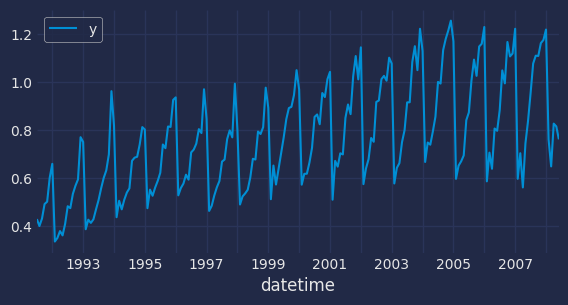

In [3]:
# Data
# ==============================================================================
display(data.head(3))

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 3))
data['y'].plot(ax=ax)
ax.legend()
plt.show()

In [4]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 5,
                 window_features = window_features
             )

forecaster.fit(y=data['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4 5] 
Window features: ['roll_mean_5', 'roll_sum_5'] 
Window size: 5 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-04-29 11:18:38 
Last fit date: 2025-04-29 11:18:38 
Skforecast version: 0.14.0 
Python version: 3.12.9 
Forecaster id: None

In [5]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data['y'])

In [6]:
# Predictors matrix
# ==============================================================================
X_train.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
datetime,,,,,,,
1991-12-01,0.502369,0.492543,0.432159,0.400906,0.429795,0.451554,2.257772
1992-01-01,0.602652,0.502369,0.492543,0.432159,0.400906,0.486126,2.430629
1992-02-01,0.660119,0.602652,0.502369,0.492543,0.432159,0.537968,2.689842


In [7]:
# Target variable matrix
# ==============================================================================
y_train.head(3)

datetime
1991-12-01    0.602652
1992-01-01    0.660119
1992-02-01    0.336220
Freq: MS, Name: y, dtype: float64

We can obtain the training predictions using the `predict` method of the regressor stored inside the forecaster object. By examining the predictions on the training data, analysts can get a better understanding of how the model is performing and make adjustments as necessary.

In [8]:
# Training predictions using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressor.predict(X_train)
predictions_training[:4]

array([0.49322601, 0.6376049 , 0.58531495, 0.44962278])

Skforecast provides the `create_predict_X` method to generate the matrices that the forecaster is using to make predictions. This method can be used to gain insight into the specific data manipulations that occur during the prediction process.

In [9]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=5)
X_predict

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
2008-07-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536
2008-08-01,0.865361,0.762137,0.816255,0.827887,0.649435,0.784215,3.921075
2008-09-01,0.878167,0.865361,0.762137,0.816255,0.827887,0.829961,4.149806
2008-10-01,0.806708,0.878167,0.865361,0.762137,0.816255,0.825726,4.128628
2008-11-01,0.873597,0.806708,0.878167,0.865361,0.762137,0.837194,4.185970


In [10]:
# Predict using the internal regressor
# ==============================================================================
predictions = forecaster.regressor.predict(X_predict)
predictions

array([0.86536052, 0.87816664, 0.80670845, 0.87359717, 0.96601636])

## ForecasterDirect

In [11]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterDirect(
                 regressor       = Ridge(random_state=123),
                 steps           = 3,
                 lags            = 5,
                 window_features = window_features
             )

forecaster.fit(y=data['y'])

Two steps are required to extract the training matrices. One to create the entire training matrix and a second to subset the data needed for each model (step).

In [12]:
# Create the whole train matrix
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data['y'])

# Extract X and y for step 1
X_train_1, y_train_1 = forecaster.filter_train_X_y_for_step(
                           step          = 1,
                           X_train       = X_train,
                           y_train       = y_train,
                           remove_suffix = False
                       )

X_train_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
datetime,,,,,,,
1991-12-01,0.502369,0.492543,0.432159,0.400906,0.429795,0.451554,2.257772
1992-01-01,0.602652,0.502369,0.492543,0.432159,0.400906,0.486126,2.430629
1992-02-01,0.660119,0.602652,0.502369,0.492543,0.432159,0.537968,2.689842
1992-03-01,0.336220,0.660119,0.602652,0.502369,0.492543,0.518781,2.593903


In [13]:
# Target variable matrix for step 1
# ==============================================================================
y_train_1.head(3)

datetime
1991-12-01    0.602652
1992-01-01    0.660119
1992-02-01    0.336220
Freq: MS, Name: y_step_1, dtype: float64

In [14]:
# Internal regressors {step: regressor}
# ==============================================================================
forecaster.regressors_

{1: Ridge(random_state=123),
 2: Ridge(random_state=123),
 3: Ridge(random_state=123)}

In [15]:
# Step 1 training predictions using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressors_[1].predict(X_train_1)
predictions_training[:4]

array([0.5960254 , 0.6592509 , 0.70209408, 0.50312286])

In [16]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=None)  # All steps
X_predict

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
2008-07-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536
2008-08-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536
2008-09-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536


In [17]:
# Step 1 predictions using the internal regressor
# ==============================================================================
predictions = forecaster.regressors_[1].predict(X_predict)
predictions

array([0.78198225, 0.78198225, 0.78198225])

## Creating matrices when including transformations

If any [data transformations](../user_guides/sklearn-transformers-and-pipeline.html) and/or [differentiation](../user_guides/time-series-differentiation.html), are applied, they will affect the output matrices. Consequently, the predictions generated in this transformed scale may require additional steps to revert back to the original data scale.

In [18]:
# Create and fit ForecasterRecursive
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 5,
                 window_features = window_features,
                 transformer_y   = StandardScaler(),
                 differentiation = 1
             )

forecaster.fit(y=data['y'])

In [19]:
# Training predictions with transformations
# ==============================================================================
X_train_transformed, y_train_transformed = forecaster.create_train_X_y(y=data['y'])

# Training predictions using the internal regressor
predictions_transformed = forecaster.regressor.predict(X_train_transformed)

# Revert differentiation (only if differentiation is not None)
predictions_transformed = forecaster.differentiator.inverse_transform_training(predictions_transformed)

# Revert transformation (only if transformer_y is not None)
predictions_training = forecaster.transformer_y.inverse_transform(predictions_transformed.reshape(-1, 1))
predictions_training.ravel()[:4]

array([0.5547262 , 0.3597327 , 0.39960716, 0.42227145])

In [20]:
# Predict using the internal regressor with transformation
# ==============================================================================
X_predict_transformed = forecaster.create_predict_X(steps=5)

# Predict using the internal regressor
predictions_transformed = forecaster.regressor.predict(X_predict_transformed)

# Revert differentiation (only if differentiation is not None)
predictions_transformed = forecaster.differentiator.inverse_transform_next_window(predictions_transformed)

# Revert transformation (only if transformer_y is not None)
predictions = forecaster.transformer_y.inverse_transform(predictions_transformed.reshape(-1, 1))
predictions.ravel()[:4]

/home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skforecast/recursive/_forecaster_recursive.py:1385: DataTransformationWarning: The output matrix is in the transformed scale due to the inclusion of transformations or differentiation in the Forecaster. As a result, any predictions generated using this matrix will also be in the transformed scale. Please refer to the documentation for more details: https://skforecast.org/latest/user_guides/training-and-prediction-matrices.html 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTransformationWarning)
  warnings.warn(


array([0.88563047, 0.62235217, 0.54433454, 0.56906843])

As before, when using a <code>ForecasterDirect</code>, two steps are required to extract the training matrices. One to create the entire training matrix and a second to subset the data needed for each model (step).

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

If the <code>ForecasterDirect</code> includes <a href="../user_guides/time-series-differentiation.html">differentiation</a>, the model in step 1 must be used if you want to reverse the differentiation of the training time series with the <code>inverse_transform_training</code> method.

</div>

In [21]:
# Create and fit ForecasterDirect
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterDirect(
                 regressor       = Ridge(random_state=123),
                 steps           = 3,
                 lags            = 5,
                 window_features = window_features,
                 transformer_y   = StandardScaler(),
                 differentiation = 1
             )

forecaster.fit(y=data['y'])

In [22]:
# Training predictions with transformations
# ==============================================================================
X_train_transformed, y_train_transformed = forecaster.create_train_X_y(y=data['y'])

# Extract X and y for step 1
X_train_transformed_1, y_train_transformed_1 = forecaster.filter_train_X_y_for_step(
                                                   step          = 1,
                                                   X_train       = X_train_transformed,
                                                   y_train       = y_train_transformed,
                                                   remove_suffix = False
                                               )

# Training predictions using the internal regressor for step 1
predictions_transformed = forecaster.regressors_[1].predict(X_train_transformed_1)

# Revert differentiation (only if differentiation is not None)
predictions_transformed = forecaster.differentiator.inverse_transform_training(predictions_transformed)

# Revert transformation (only if transformer_y is not None)
predictions_training = forecaster.transformer_y.inverse_transform(predictions_transformed.reshape(-1, 1))
predictions_training.ravel()[:4]

array([0.58659215, 0.55767068, 0.58243553, 0.58782361])

In [23]:
# Predict using the internal regressor with transformation
# ==============================================================================
X_predict_transformed = forecaster.create_predict_X(steps=None)  # All steps

# Predict using the internal regressor for step 1
predictions_transformed = forecaster.regressors_[1].predict(X_predict_transformed)

# Revert differentiation (only if differentiation is not None)
predictions_transformed = forecaster.differentiator.inverse_transform_next_window(predictions_transformed)

# Revert transformation (only if transformer_y is not None)
predictions = forecaster.transformer_y.inverse_transform(predictions_transformed.reshape(-1, 1))
predictions.ravel()[:4]

/home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skforecast/direct/_forecaster_direct.py:1388: DataTransformationWarning: The output matrix is in the transformed scale due to the inclusion of transformations or differentiation in the Forecaster. As a result, any predictions generated using this matrix will also be in the transformed scale. Please refer to the documentation for more details: https://skforecast.org/latest/user_guides/training-and-prediction-matrices.html 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTransformationWarning)
  warnings.warn(


array([0.85739057, 0.95264414, 1.04789772])

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To reverse the <a href="../user_guides/sklearn-transformers-and-pipeline.html">data transformation</a>, you can also use one of these skforecast functions: <a href="../api/utils.html#skforecast.utils.utils.transform_numpy"><code>transform_numpy</code></a>, <a href="../api/utils.html#skforecast.utils.utils.transform_series"><code>transform_series</code></a>, <a href="../api/utils.html#skforecast.utils.utils.transform_dataframe"><code>transform_dataframe</code></a>.

```python
from skforecast.utils import transform_numpy

predictions = transform_numpy(
                  array             = predictions_transformed,
                  transformer       = forecaster.transformer_y,
                  fit               = False,
                  inverse_transform = True
              )
```

</div>

## ForecasterRecursiveMultiSeries

,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922


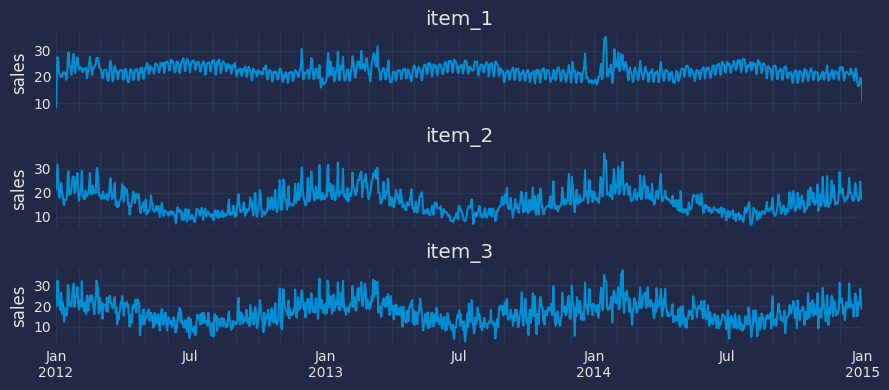

In [24]:
# Data
# ==============================================================================
display(data_multiseries.head(3))

# Plot
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4), sharex=True)

for i, col in enumerate(data_multiseries.columns):
    data_multiseries[col].plot(ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('sales')
    axes[i].set_title(col)

fig.tight_layout()
plt.show();

In [25]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterRecursiveMultiSeries(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 5,
                 window_features = window_features,
                 encoding        = 'ordinal'
             )

forecaster.fit(series=data_multiseries)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4 5] 
Window features: ['roll_mean_5', 'roll_sum_5'] 
Window size: 5 
Series encoding: ordinal 
Series names (levels): item_1, item_2, item_3 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'item_1': ['2012-01-01', '2015-01-01'], 'item_2': ['2012-01-01', '2015-01-01'],
    'item_3': ['2012-01-01', '2015-01-01'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-04-29 11:18:40 
Last fit date: 2025-04-29 11:18:40 
Skforecast version: 0.14.0 
Python version: 3.12.9 
Forecaster id: None

In [26]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(series=data_multiseries)

Depending on the [series encoding](../user_guides/independent-multi-time-series-forecasting.html#series-encoding-in-multi-series) selected, the column(s) generated to identify the series to which the observations belong may be different. In this case, the column `_level_skforecast` is generated as `encoding = 'ordinal'`.

In [27]:
# Predictors matrix
# ==============================================================================
X_train.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5,_level_skforecast
date,,,,,,,,
2012-01-06,21.379238,25.895533,27.549099,22.777826,8.253175,21.170974,105.854870,0
2012-01-07,21.106643,21.379238,25.895533,27.549099,22.777826,23.741668,118.708338,0
2012-01-08,20.533871,21.106643,21.379238,25.895533,27.549099,23.292877,116.464384,0


In [28]:
# Target variable matrix
# ==============================================================================
y_train.head(3)

date
2012-01-06    21.106643
2012-01-07    20.533871
2012-01-08    20.069327
Name: y, dtype: float64

We can obtain the training predictions using the `predict` method of the regressor stored inside the forecaster object. By examining the predictions on the training data, analysts can get a better understanding of how the model is performing and make adjustments as necessary.

In [29]:
# Training predictions using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressor.predict(X_train)
predictions_training[:4]

array([19.54628549, 22.29989602, 20.10135048, 20.97563208])

Skforecast provides the `create_predict_X` method to generate the matrices that the forecaster is using to make predictions. This method can be used to gain insight into the specific data manipulations that occur during the prediction process.

In [30]:
# Create input matrix for predict method
# ==============================================================================
X_predict_dict = forecaster.create_predict_X(steps=5, levels=None)  # All levels

# Check 'item_1' matrix
X_predict_item_1 = X_predict_dict['item_1']
X_predict_item_1.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5,_level_skforecast
2015-01-02,10.496302,18.721223,18.857026,19.611623,17.329233,17.003081,85.015406,0.0
2015-01-03,13.614696,10.496302,18.721223,18.857026,19.611623,16.260174,81.300869,0.0
2015-01-04,14.526244,13.614696,10.496302,18.721223,18.857026,15.243098,76.215490,0.0
2015-01-05,16.802037,14.526244,13.614696,10.496302,18.721223,14.832100,74.160501,0.0
2015-01-06,13.888023,16.802037,14.526244,13.614696,10.496302,13.865460,69.327302,0.0


In [31]:
# Predict 'item_1' using the internal regressor
# ==============================================================================
predictions_item_1 = forecaster.regressor.predict(X_predict_item_1)
predictions_item_1

array([13.61469596, 14.5262436 , 16.80203691, 13.88802319, 15.13547167])

## ForecasterDirectMultiVariate

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01 00:00:00,8.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,19.0
2019-01-01 01:00:00,8.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,26.0
2019-01-01 02:00:00,8.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,31.0


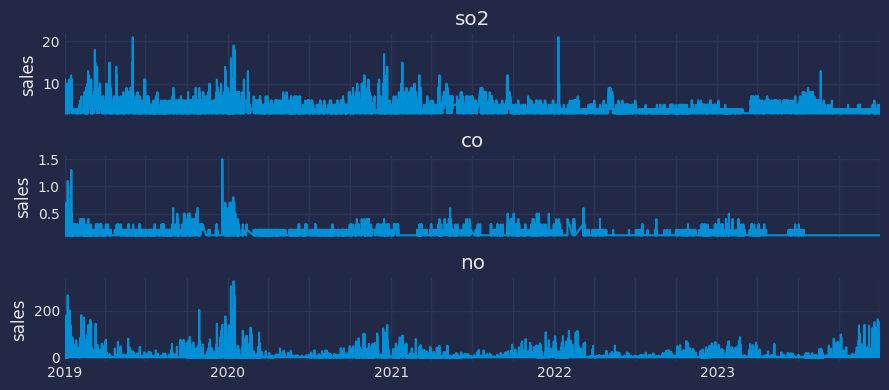

In [32]:
# Data
# ==============================================================================
display(data_multivariate.head(3))

# Plot
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4), sharex=True)

for i, col in enumerate(data_multivariate.columns[:3]):
    data_multivariate[col].plot(ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('sales')
    axes[i].set_title(col)

fig.tight_layout()
plt.show();

In [33]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterDirectMultiVariate(
                 regressor       = Ridge(random_state=123),
                 level           = 'co',
                 steps           = 3,
                 lags            = 3,
                 window_features = window_features
             )

forecaster.fit(series=data_multivariate)
forecaster

============================ 
ForecasterDirectMultiVariate 
============================ 
Regressor: Ridge 
Target series (level): co 
Lags: [1 2 3] 
Window features: ['roll_mean_5', 'roll_sum_5'] 
Window size: 5 
Maximum steps to predict: 3 
Multivariate series: so2, co, no, no2, pm10, nox, o3, veloc., direc., pm2.5 
Exogenous included: False 
Exogenous names: None 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2023-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None,
    'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2025-04-29 11:18:41 
Last fit date: 2025-04-29 11:18:41 
Skforecast version: 0.14.0 
Python version: 3.12.9 
Forecaster id: None

In [34]:
# Create the whole train matrix
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(series=data_multivariate)

# Extract X and y for step 1
X_train_1, y_train_1 = forecaster.filter_train_X_y_for_step(
                           step          = 1,
                           X_train       = X_train,
                           y_train       = y_train,
                           remove_suffix = False
                       )

print("Columns :", list(X_train_1.columns))
X_train_1.head(3)

Columns : ['so2_lag_1', 'so2_lag_2', 'so2_lag_3', 'so2_roll_mean_5', 'so2_roll_sum_5', 'co_lag_1', 'co_lag_2', 'co_lag_3', 'co_roll_mean_5', 'co_roll_sum_5', 'no_lag_1', 'no_lag_2', 'no_lag_3', 'no_roll_mean_5', 'no_roll_sum_5', 'no2_lag_1', 'no2_lag_2', 'no2_lag_3', 'no2_roll_mean_5', 'no2_roll_sum_5', 'pm10_lag_1', 'pm10_lag_2', 'pm10_lag_3', 'pm10_roll_mean_5', 'pm10_roll_sum_5', 'nox_lag_1', 'nox_lag_2', 'nox_lag_3', 'nox_roll_mean_5', 'nox_roll_sum_5', 'o3_lag_1', 'o3_lag_2', 'o3_lag_3', 'o3_roll_mean_5', 'o3_roll_sum_5', 'veloc._lag_1', 'veloc._lag_2', 'veloc._lag_3', 'veloc._roll_mean_5', 'veloc._roll_sum_5', 'direc._lag_1', 'direc._lag_2', 'direc._lag_3', 'direc._roll_mean_5', 'direc._roll_sum_5', 'pm2.5_lag_1', 'pm2.5_lag_2', 'pm2.5_lag_3', 'pm2.5_roll_mean_5', 'pm2.5_roll_sum_5']


,so2_lag_1,so2_lag_2,so2_lag_3,so2_roll_mean_5,so2_roll_sum_5,co_lag_1,co_lag_2,co_lag_3,co_roll_mean_5,co_roll_sum_5,...,direc._lag_1,direc._lag_2,direc._lag_3,direc._roll_mean_5,direc._roll_sum_5,pm2.5_lag_1,pm2.5_lag_2,pm2.5_lag_3,pm2.5_roll_mean_5,pm2.5_roll_sum_5
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 05:00:00,5.777693,4.969880,3.354255,4.162068,20.810338,-0.447961,-0.447961,-0.447961,-0.125168,-0.625841,...,0.538214,0.528519,0.567299,0.673943,3.369715,2.493131,2.493131,2.613291,2.156683,10.783416
2019-01-01 06:00:00,4.969880,5.777693,4.969880,4.485193,22.425964,-0.447961,-0.447961,-0.447961,-0.447961,-2.239803,...,0.644858,0.538214,0.528519,0.615774,3.078868,1.772172,2.493131,2.493131,2.276843,11.384215
2019-01-01 07:00:00,4.969880,4.969880,5.777693,4.808318,24.041589,-0.447961,-0.447961,-0.447961,-0.447961,-2.239803,...,0.751502,0.644858,0.538214,0.606079,3.030393,0.570573,1.772172,2.493131,1.988459,9.942297


In [35]:
# Target variable matrix for step 1
# ==============================================================================
y_train_1.head(3)

datetime
2019-01-01 05:00:00   -0.447961
2019-01-01 06:00:00   -0.447961
2019-01-01 07:00:00   -0.447961
Freq: h, Name: co_step_1, dtype: float64

In [36]:
# Internal regressors {step: regressor}
# ==============================================================================
forecaster.regressors_

{1: Ridge(random_state=123),
 2: Ridge(random_state=123),
 3: Ridge(random_state=123)}

In [37]:
# Step 1 training predictions using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressors_[1].predict(X_train_1)
predictions_training[:4]

array([-0.33195755, -0.41491613, -0.42473316, -0.26854783])

In [38]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=None)  # All steps
X_predict

/home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skforecast/direct/_forecaster_direct_multivariate.py:1702: DataTransformationWarning: The output matrix is in the transformed scale due to the inclusion of transformations or differentiation in the Forecaster. As a result, any predictions generated using this matrix will also be in the transformed scale. Please refer to the documentation for more details: https://skforecast.org/latest/user_guides/training-and-prediction-matrices.html 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTransformationWarning)
  warnings.warn(


,so2_lag_1,so2_lag_2,so2_lag_3,so2_roll_mean_5,so2_roll_sum_5,co_lag_1,co_lag_2,co_lag_3,co_roll_mean_5,co_roll_sum_5,...,direc._lag_1,direc._lag_2,direc._lag_3,direc._roll_mean_5,direc._roll_sum_5,pm2.5_lag_1,pm2.5_lag_2,pm2.5_lag_3,pm2.5_roll_mean_5,pm2.5_roll_sum_5
2024-01-01 00:00:00,-0.684809,-0.684809,-0.684809,-0.684809,-3.424043,-0.447961,-0.447961,-0.447961,-0.447961,-2.239803,...,0.790282,0.780587,0.790282,0.770892,3.85446,-0.631026,-0.510866,-0.631026,-0.486834,-2.43417
2024-01-01 01:00:00,-0.684809,-0.684809,-0.684809,-0.684809,-3.424043,-0.447961,-0.447961,-0.447961,-0.447961,-2.239803,...,0.790282,0.780587,0.790282,0.770892,3.85446,-0.631026,-0.510866,-0.631026,-0.486834,-2.43417
2024-01-01 02:00:00,-0.684809,-0.684809,-0.684809,-0.684809,-3.424043,-0.447961,-0.447961,-0.447961,-0.447961,-2.239803,...,0.790282,0.780587,0.790282,0.770892,3.85446,-0.631026,-0.510866,-0.631026,-0.486834,-2.43417


In [39]:
# Step 1 predictions using the internal regressor
# ==============================================================================
predictions = forecaster.regressors_[1].predict(X_predict)
predictions

array([-0.37588817, -0.37588817, -0.37588817])

## Creating matrices when including transformations multiple series

If any [data transformations](../user_guides/sklearn-transformers-and-pipeline.html) and/or [differentiation](../user_guides/time-series-differentiation.html), are applied, they will affect the output matrices. Consequently, the predictions generated in this transformed scale may require additional steps to revert back to the original data scale.

In [40]:
# Create and fit forecaster ForecasterRecursiveMultiSeries
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 5,
                 window_features    = window_features,
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler(),
                 differentiation    = 1
             )

forecaster.fit(series=data_multiseries)

In [41]:
# item_1 training predictions with transformations
# ==============================================================================
X_train_transformed, y_train_transformed = forecaster.create_train_X_y(series=data_multiseries)

# Ordinal encoding mapping 
print("Ordinal encoding mapping (_level_skforecast) :", forecaster.encoding_mapping_)

# Select `item_1` rows
X_train_item_1_transformed = X_train_transformed[
    X_train_transformed['_level_skforecast'] == forecaster.encoding_mapping_['item_1']
]

# Training predictions using the internal regressor
predictions_item_1_transformed = forecaster.regressor.predict(X_train_item_1_transformed)

# Revert differentiation (only if differentiation is not None)
predictions_item_1_transformed = forecaster.differentiator_['item_1'].inverse_transform_training(
    predictions_item_1_transformed
)

# Revert transformation (only if transformer_series is not None)
predictions_item_1_training = forecaster.transformer_series_['item_1'].inverse_transform(
    predictions_item_1_transformed.reshape(-1, 1)
)
predictions_item_1_training.ravel()[:4]

Ordinal encoding mapping (_level_skforecast) : {'item_1': 0, 'item_2': 1, 'item_3': 2}


array([19.03003376, 19.87765376, 20.27301849, 21.50016429])

In [42]:
# Predict using the internal regressor with transformation
# ==============================================================================
X_predict_dict_transformed = forecaster.create_predict_X(steps=5, levels=None)  # All levels

# Select 'item_1' matrix
X_predict_item_1_transformed = X_predict_dict_transformed['item_1']

# Predict 'item_1' using the internal regressor
predictions_item_1_transformed = forecaster.regressor.predict(X_predict_item_1_transformed)

# Revert differentiation (only if differentiation is not None)
predictions_item_1_transformed = forecaster.differentiator_['item_1'].inverse_transform_next_window(
    predictions_item_1_transformed
)

# Revert transformation (only if transformer_series is not None)
predictions_item_1 = forecaster.transformer_series_['item_1'].inverse_transform(
    predictions_item_1_transformed.reshape(-1, 1)
)
predictions_item_1.ravel()[:4]

/home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skforecast/recursive/_forecaster_recursive_multiseries.py:2086: DataTransformationWarning: The output matrix is in the transformed scale due to the inclusion of transformations or differentiation in the Forecaster. As a result, any predictions generated using this matrix will also be in the transformed scale. Please refer to the documentation for more details: https://skforecast.org/latest/user_guides/training-and-prediction-matrices.html 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTransformationWarning)
  warnings.warn(


array([11.9118058 , 13.90669023, 14.61048366, 14.68379556])

As before, when using a <code>ForecasterDirectMultiVariate</code>, two steps are required to extract the training matrices. One to create the entire training matrix and a second to subset the data needed for each model (step).

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

If the <code>ForecasterDirectMultiVariate</code> includes <a href="../user_guides/time-series-differentiation.html">differentiation</a>, the model in step 1 must be used if you want to reverse the differentiation of the training time series with the <code>inverse_transform_training</code> method.

</div>

In [43]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterDirectMultiVariate(
                 regressor          = Ridge(random_state=123),
                 level              = 'co',
                 steps              = 3,
                 lags               = 3,
                 window_features    = window_features,
                 transformer_series = StandardScaler(),
                 differentiation    = 1
             )

forecaster.fit(series=data_multivariate)

In [44]:
# Training predictions with transformations
# ==============================================================================
X_train_transformed, y_train_transformed = forecaster.create_train_X_y(series=data_multivariate)

# Extract X and y for step 1
X_train_transformed_1, y_train_transformed_1 = forecaster.filter_train_X_y_for_step(
                                                   step          = 1,
                                                   X_train       = X_train_transformed,
                                                   y_train       = y_train_transformed,
                                                   remove_suffix = False
                                               )

# Training predictions using the internal regressor for step 1
predictions_transformed = forecaster.regressors_[1].predict(X_train_transformed_1)

# Revert differentiation (only if differentiation is not None)
predictions_transformed = forecaster.differentiator_['co'].inverse_transform_training(
    predictions_transformed
)

# Revert transformation (only if transformer_series is not None)
predictions_training = forecaster.transformer_series_['co'].inverse_transform(
    predictions_transformed.reshape(-1, 1)
)
predictions_training.ravel()[:4]

array([0.09856102, 0.09112238, 0.09364988, 0.09022939])

In [45]:
# Predict using the internal regressor with transformation
# ==============================================================================
X_predict_transformed = forecaster.create_predict_X(steps=None)  # All steps

# Predict using the internal regressor for step 1
predictions_transformed = forecaster.regressors_[1].predict(X_predict_transformed)

# Revert differentiation (only if differentiation is not None)
predictions_transformed = forecaster.differentiator_['co'].inverse_transform_next_window(
    predictions_transformed
)

# Revert transformation (only if transformer_y is not None)
predictions = forecaster.transformer_series_['co'].inverse_transform(
    predictions_transformed.reshape(-1, 1)
)
predictions.ravel()[:4]

/home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skforecast/direct/_forecaster_direct_multivariate.py:1702: DataTransformationWarning: The output matrix is in the transformed scale due to the inclusion of transformations or differentiation in the Forecaster. As a result, any predictions generated using this matrix will also be in the transformed scale. Please refer to the documentation for more details: https://skforecast.org/latest/user_guides/training-and-prediction-matrices.html 
 You can suppress this warning using: warnings.simplefilter('ignore', category=DataTransformationWarning)
  warnings.warn(


array([0.1004134 , 0.10082681, 0.10124021])

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To reverse the <a href="../user_guides/sklearn-transformers-and-pipeline.html">data transformation</a>, you can also use one of these skforecast functions: <a href="../api/utils.html#skforecast.utils.utils.transform_numpy"><code>transform_numpy</code></a>, <a href="../api/utils.html#skforecast.utils.utils.transform_series"><code>transform_series</code></a>, <a href="../api/utils.html#skforecast.utils.utils.transform_dataframe"><code>transform_dataframe</code></a>.

```python
from skforecast.utils import transform_numpy

predictions = transform_numpy(
                  array             = predictions_transformed,
                  transformer       = forecaster.transformer_series_['item_1'],
                  fit               = False,
                  inverse_transform = True
              )
```

</div>